## 2024 데이터 통신 설계 기말 프로젝트
### 3번 프로젝트
`tr_bit.csv`를 입력 값으로 받아 **AutoEncoder 기반의 변조**를 수행하고

AWGN 함수를 거쳐 노이즈를 추가한다.

노이즈를 추가한 입력 값을 **AutoEncoder 기반의 복조**를 이용하여 

변환한 비트스트림과 `te_bit.csv` 파일(테스트 셋)을 비교하여 에러를 계산한다 **(BER 계산)**

![project3](./assets/project3.png)

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
print(torch.cuda.is_available())

True


In [33]:
# [변경 함수]
def awgn_(input, dB_snr):
    snr = 10**(dB_snr/10)
    signal_power = 1
    awgn_power = signal_power / snr
    # 텐서 계산을 위해 텐서 타입으로 변환
    awgn_power_tensor = torch.tensor(awgn_power, dtype=torch.float32)
    awgn = torch.sqrt(awgn_power_tensor / 2)*(
        torch.randn_like(input, dtype=torch.float32)+1j*torch.randn_like(input, dtype=torch.float32)
    )
    return input + awgn

### AutoEncoder 기반 Encoder, Decoder

AutoEncoder는 데이터를 압축(encoding)하고 복원(decoding)하는 과정을 통해 입력 데이터의 중요한 특징을 학습하는 신경망입니다. 주로 비지도 학습에서 사용되며, 입력 데이터의 구조를 학습해 복원할 수 있습니다.

1. Encoder (인코더)
입력 데이터를 더 낮은 차원(잠재 공간, Latent Space)으로 압축합니다.
이 과정에서 데이터의 중요한 특징만을 학습합니다.

해당 프로젝트에서는 실수부와 허수부를 분리하여 학습을 진행하기에 input과 output은 2차원으로 진행합니다.

2. Latent Space (잠재 공간)
인코더를 통해 생성된 압축된 벡터입니다.
이 벡터는 원본 데이터의 핵심적인 특징만을 표현합니다.
3. Decoder (디코더)
잠재 공간에서 압축된 벡터를 입력받아 원래 차원으로 데이터를 복원합니다.
이상적인 경우 복원된 출력이 원본 입력과 최대한 유사하게 됩니다.

In [34]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()  # 비트 값 복원 (0~1)
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

In [35]:
# Training Set 준비
train_df = pd.read_csv('./data/tr_qpsk.csv', header=None)
# 복소수 형태로 변환
train_df[0] = train_df[0].str.replace('i', 'j')  # 'i'를 'j'로 변경 (Python 복소수 표기법에 맞춤)
train_complex_numbers = train_df[0].apply(lambda x: complex(x))

# 실수부와 허수부 분리
train_qpsk_real_parts = train_complex_numbers.apply(lambda x: x.real)
train_qpsk_imag_parts = train_complex_numbers.apply(lambda x: x.imag)

# Ground Truth (dec)
train_dec = np.loadtxt('./data/tr_dec.csv', delimiter=',')
# DataFrame 생성
train_df = pd.DataFrame({'Real': train_qpsk_real_parts, 
                         'Imaginary': train_qpsk_imag_parts, 
                         'dec': train_dec})
# PyTorch 텐서로 변환
train_x_tensor = torch.Tensor(train_df[['Real', 'Imaginary']].values)
train_y_tensor = torch.LongTensor(train_df['dec'].values)

# 미니 배치 학습을 위해 DataLoader 생성
train_data = TensorDataset(train_x_tensor, train_y_tensor)
BATCH_SIZE = 1000
train_loader = DataLoader(dataset=train_data, 
                    batch_size=BATCH_SIZE, shuffle=True)

# Test Set 준비
test_df = pd.read_csv('./data/te_qpsk.csv', header=None)
test_df[0] = test_df[0].str.replace('i', 'j')
test_complex_numbers = test_df[0].apply(lambda x: complex(x))

test_qpsk_real_parts = test_complex_numbers.apply(lambda x: x.real)
test_qpsk_imag_parts = test_complex_numbers.apply(lambda x: x.imag)
test_dec = np.loadtxt('./data/te_dec.csv', delimiter=',')

test_df = pd.DataFrame({'Real': test_qpsk_real_parts, 
                        'Imaginary': test_qpsk_imag_parts, 
                        'dec': test_dec})

# PyTorch 텐서로 변환
test_x_tensor = torch.Tensor(test_df[['Real', 'Imaginary']].values)
test_y_tensor = torch.LongTensor(test_df['dec'].values)

# 미니 배치 학습을 위해 DataLoader 생성
test_data = TensorDataset(test_x_tensor, test_y_tensor)
test_loader = DataLoader(dataset=test_data, 
                    batch_size=len(test_data), shuffle=False)


In [37]:
# GPU 사용 여부 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AutoEncoder(input_dim=2, latent_dim=2).to(device)
cel = torch.nn.MSELoss()  # 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 학습
epochs = 10
batch_size = 128
snr_db_list = range(0, 11)
model.train()
for epoch in range(epochs):
    for batch_idx, (x,y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        for snr_db in snr_db_list:
            optimizer.zero_grad()
            
            # Encoder -> AWGN 채널 -> Decoder
            encoded = model.encoder(x)
            # 복소수 형태로 변환
            encoded = torch.complex(encoded[:, 0], encoded[:, 1])
            # AWGN 채널 적용
            noisy_encoded = awgn_(encoded, snr_db)
            X_real_parts = noisy_encoded.real
            X_imag_parts = noisy_encoded.imag
            X_noise_tensor = torch.stack([torch.tensor(X_real_parts), torch.tensor(X_imag_parts)], dim=1)
            decoded = model.decoder(X_noise_tensor)
            
            # 손실 계산 및 역전파
            loss = cel(decoded, x)
            loss.backward()
            optimizer.step()
            
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

C:\Users\Kyounghwan-Kim\AppData\Local\Temp\ipykernel_33428\1505360512.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_noise_tensor = torch.stack([torch.tensor(X_real_parts), torch.tensor(X_imag_parts)], dim=1)


Epoch [1/10], Loss: 0.7363
Epoch [1/10], Loss: 0.7378
Epoch [1/10], Loss: 0.7342
Epoch [1/10], Loss: 0.7327
Epoch [1/10], Loss: 0.7280
Epoch [1/10], Loss: 0.7267
Epoch [1/10], Loss: 0.7260
Epoch [1/10], Loss: 0.7227
Epoch [1/10], Loss: 0.7191
Epoch [1/10], Loss: 0.7158
Epoch [1/10], Loss: 0.7131
Epoch [1/10], Loss: 0.6794
Epoch [1/10], Loss: 0.6763
Epoch [1/10], Loss: 0.6755
Epoch [1/10], Loss: 0.6774
Epoch [1/10], Loss: 0.6748
Epoch [1/10], Loss: 0.6763
Epoch [1/10], Loss: 0.6722
Epoch [1/10], Loss: 0.6715
Epoch [1/10], Loss: 0.6678
Epoch [1/10], Loss: 0.6667
Epoch [1/10], Loss: 0.6635
Epoch [1/10], Loss: 0.6305
Epoch [1/10], Loss: 0.6336
Epoch [1/10], Loss: 0.6336
Epoch [1/10], Loss: 0.6335
Epoch [1/10], Loss: 0.6327
Epoch [1/10], Loss: 0.6309
Epoch [1/10], Loss: 0.6313
Epoch [1/10], Loss: 0.6285
Epoch [1/10], Loss: 0.6284
Epoch [1/10], Loss: 0.6271
Epoch [1/10], Loss: 0.6250
Epoch [1/10], Loss: 0.6146
Epoch [1/10], Loss: 0.6151
Epoch [1/10], Loss: 0.6178
Epoch [1/10], Loss: 0.6198
E

### SNR에 따른 BER 계산 및 그래프 작성
1. Eval 코드 결과값 수정
 - Decoder를 거친 예측 데이터의 차원이 [n,2,2] 형태로 나와 bit로 변환이 필요했음.
 - 예측 데이터의 한 Row가 다음과 같은 형태로 나와 `[[1.9400e-01, 1.9887e-01],[1.0507e-11, 4.3291e-09]]` 아래의 그림과 같이 변환함.
 ![alt text](./assets/convert.png)

C:\Users\Kyounghwan-Kim\AppData\Local\Temp\ipykernel_33428\840702422.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_noise_tensor = torch.stack([torch.tensor(X_real_parts), torch.tensor(X_imag_parts)], dim=1)


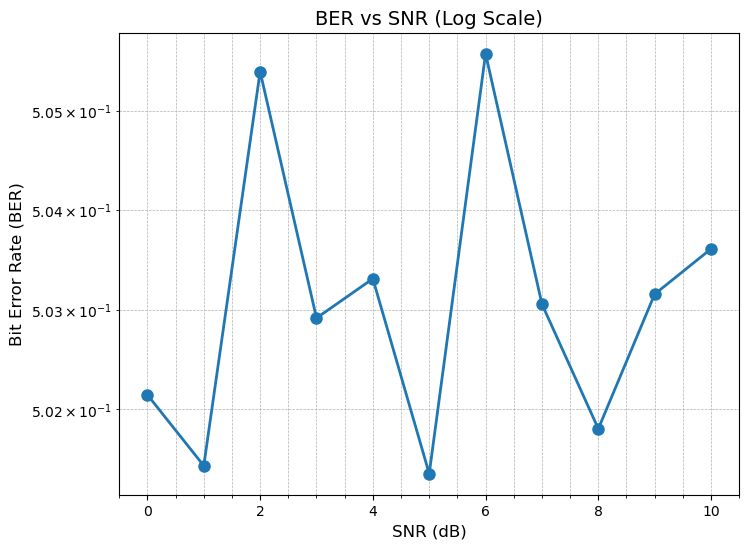

In [41]:
# BER 계산 함수
def calculate_ber(original_bits, predicted_bits):
    original_bits = np.array(original_bits)
    predicted_bits = np.array(predicted_bits)

    # Count the number of bit errors
    bit_errors = np.sum(original_bits != predicted_bits)

    # Calculate BER
    ber = bit_errors / len(original_bits)
    return ber

# BER 그래프 작성 함수
def plot_ber(snr_values, ber_values):
    plt.figure(figsize=(8, 6))
    plt.semilogy(snr_values, ber_values, marker='o', linestyle='-', linewidth=2, markersize=8)
    plt.title("BER vs SNR (Log Scale)", fontsize=14)
    plt.xlabel("SNR (dB)", fontsize=12)
    plt.ylabel("Bit Error Rate (BER)", fontsize=12)
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.minorticks_on()
    plt.show()

# SNR에 따른 BER 계산 및 그래프 작성
def evaluate_and_plot_ber(model, X_test, y_test, snr_range):
    
    for snr_db in snr_range:
        model.eval()
        with torch.no_grad():
            encoded = model.encoder(X_test)
            noisy_encoded = awgn_(encoded, snr_db)
            X_real_parts = noisy_encoded.real
            X_imag_parts = noisy_encoded.imag
            X_noise_tensor = torch.stack([torch.tensor(X_real_parts), torch.tensor(X_imag_parts)], dim=1)
            decoded = model.decoder(X_noise_tensor)
            convert_bits = []
            # 복원된 비트를 0 또는 1로 변환
            for i in range(len(decoded)):
                for j in range(2):
                    if decoded[i][j][0] < decoded[i][j][1]:
                        convert_bits.append(1)
                    else:
                        convert_bits.append(0)
            # 원래 비트와 복원 비트 비교
            ber = calculate_ber(y_test, np.array(convert_bits))
            ber_values.append(ber)


# SNR 범위 설정
snr_range = range(0, 11)  # 0 dB부터 10 dB까지
ber_values = []

X_test, y_test = next(iter(test_loader))
X_test = X_test.to(device)
y_test = pd.read_csv('./data/te_bits.csv', header=None)
flatten_y_test = y_test.values.flatten()
# BER 평가 및 그래프 작성
evaluate_and_plot_ber(model, X_test, flatten_y_test, snr_range)

plot_ber(snr_range, ber_values)


프로젝트 3의 경우도 예상과 달리 BER이 떨어지지 않는 현상이 발생하였다. AutoEncoder의 이해가 부족하여 데이터 변환 시의 문제도 고려해봐야 할 듯 하다.